In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd


# Define the neural network architecture
class ParallelNN(nn.Module):
    def __init__(self, input1_size, hidden_size, num_classes):
        super(ParallelNN, self).__init__()

        # Define the first pipeline
        self.pipeline1 = nn.Sequential(
            nn.Linear(input1_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
        )

        # Define the final classification layer
        self.classification = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x1):
        out1 = self.pipeline1(x1)

        # Apply the final classification layer
        final_out = self.classification(out1)
        return final_out

# Define the input sizes, hidden size, and number of classes
#input1_size = 10  # Change this to match the number of features in your first dataset
#input2_size = 8   # Change this to match the number of features in your second dataset
#hidden_size = 64
#num_classes = 3   # Change this to match the number of classes in your classification task

# Initialize the model
#model = ParallelNN(input1_size, input2_size, hidden_size, num_classes)

# Define your loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Load the data from a CSV file
NMR_csv_name = '../data/PD_Serum_Metabolomics_Final_NMR.csv'
MS_csv_name = '../data/preprocessed_data_PD.csv'

NMR_data = pd.read_csv(NMR_csv_name)
MS_data = pd.read_csv(MS_csv_name)

# Labels are first column of MS data
# Remove 305h row from MS data, because it is missing from NMR data
data1 = torch.tensor(NMR_data.values, dtype=torch.float32)
data2 = torch.tensor(MS_data.drop(index=305).iloc[:, 1:].values, dtype=torch.float32)
labels = torch.tensor(MS_data.drop(index=305).iloc[:, 0].values, dtype=torch.long)

# Concatenate the data
data = torch.cat((data1, data2), dim=1)

# Normalize the data
scaler = QuantileTransformer()
data = torch.tensor(scaler.fit_transform(data), dtype=torch.float32)

# Define model, loss function, and optimizer
model = ParallelNN(input1_size=data.shape[1], hidden_size=32, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
k_folds = 5

# Prepare data loaders
dataset = TensorDataset(data, labels)
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))], generator=torch.Generator().manual_seed(10))
train_loader = DataLoader(train_set, batch_size=31, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=False)

# Training loop
def train(model, dataloader, criterion, optimizer, best_loss):
    pbar = tqdm(dataloader)
    correct = 0
    running_loss = 0
    

    for (data1, labels) in pbar:
        model.train()


        optimizer.zero_grad()
        outputs = model(data1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * data1.size(0)

        loss.backward()
        optimizer.step()

        # correct += (outputs.argmax(dim=1) == labels).float().sum()
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        accuracy = correct / 257 # Used in sampling

        
        # Validation loop
        val_loss = 0
        val_accuracy = 0
        model.eval()

        with torch.no_grad():
            for (data1_v, labels_v) in val_loader:

                outputs = model(data1_v)
                loss = criterion(outputs, labels_v)
                val_loss += loss.item()
                val_accuracy += (outputs.argmax(dim=1) == labels_v).float().sum()
         
        pbar.set_description(f"Loss: {running_loss / 257:.4f}, Accuracy: {accuracy:.4f}")

    val_loss /= len(val_loader)
    val_accuracy /= len(val_set)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_one_pipeline_PD.pth')

    torch.save(model.state_dict(), 'latest_model_one_pipeline_PD.pth')

    return val_loss, val_accuracy, running_loss / 257, accuracy
        

/Users/franky/Downloads/445-env/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(


Epoch 1/30


Loss: 0.7094, Accuracy: 0.4553: 100%|██████████| 9/9 [00:00<00:00, 20.88it/s]


Validation Loss: 0.7169, Validation Accuracy: 0.4000
Epoch 2/30


Loss: 0.6797, Accuracy: 0.5798: 100%|██████████| 9/9 [00:00<00:00, 18.47it/s]


Validation Loss: 0.6856, Validation Accuracy: 0.6154
Epoch 3/30


Loss: 0.6377, Accuracy: 0.6148: 100%|██████████| 9/9 [00:00<00:00, 23.23it/s]


Validation Loss: 0.6264, Validation Accuracy: 0.6154
Epoch 4/30


Loss: 0.5191, Accuracy: 0.7276: 100%|██████████| 9/9 [00:00<00:00, 19.77it/s]


Validation Loss: 0.5761, Validation Accuracy: 0.6615
Epoch 5/30


Loss: 0.4299, Accuracy: 0.8288: 100%|██████████| 9/9 [00:00<00:00, 23.78it/s]


Validation Loss: 0.6208, Validation Accuracy: 0.7077
Epoch 6/30


Loss: 0.2589, Accuracy: 0.8988: 100%|██████████| 9/9 [00:00<00:00, 20.90it/s]


Validation Loss: 0.5558, Validation Accuracy: 0.7538
Epoch 7/30


Loss: 0.2371, Accuracy: 0.9144: 100%|██████████| 9/9 [00:00<00:00, 22.90it/s]


Validation Loss: 0.5672, Validation Accuracy: 0.7231
Epoch 8/30


Loss: 0.1995, Accuracy: 0.9533: 100%|██████████| 9/9 [00:00<00:00, 20.65it/s]


Validation Loss: 0.5327, Validation Accuracy: 0.7538
Epoch 9/30


Loss: 0.1591, Accuracy: 0.9572: 100%|██████████| 9/9 [00:00<00:00, 23.74it/s]


Validation Loss: 0.5473, Validation Accuracy: 0.7077
Epoch 10/30


Loss: 0.1478, Accuracy: 0.9650: 100%|██████████| 9/9 [00:00<00:00, 20.83it/s]


Validation Loss: 0.5607, Validation Accuracy: 0.7231
Epoch 11/30


Loss: 0.1462, Accuracy: 0.9611: 100%|██████████| 9/9 [00:00<00:00, 24.68it/s]


Validation Loss: 0.5647, Validation Accuracy: 0.7231
Epoch 12/30


Loss: 0.1562, Accuracy: 0.9572: 100%|██████████| 9/9 [00:00<00:00, 20.79it/s]


Validation Loss: 0.5708, Validation Accuracy: 0.7385
Epoch 13/30


Loss: 0.1484, Accuracy: 0.9455: 100%|██████████| 9/9 [00:00<00:00, 23.36it/s]


Validation Loss: 0.5707, Validation Accuracy: 0.7231
Epoch 14/30


Loss: 0.1521, Accuracy: 0.9494: 100%|██████████| 9/9 [00:00<00:00, 21.58it/s]


Validation Loss: 0.5663, Validation Accuracy: 0.7231
Epoch 15/30


Loss: 0.1470, Accuracy: 0.9572: 100%|██████████| 9/9 [00:00<00:00, 23.10it/s]


Validation Loss: 0.5660, Validation Accuracy: 0.7385
Epoch 16/30


Loss: 0.1272, Accuracy: 0.9689: 100%|██████████| 9/9 [00:00<00:00, 22.33it/s]


Validation Loss: 0.5692, Validation Accuracy: 0.7385
Epoch 17/30


Loss: 0.1158, Accuracy: 0.9689: 100%|██████████| 9/9 [00:00<00:00, 23.26it/s]


Validation Loss: 0.5588, Validation Accuracy: 0.7231
Epoch 18/30


Loss: 0.1504, Accuracy: 0.9572: 100%|██████████| 9/9 [00:00<00:00, 21.18it/s]


Validation Loss: 0.5707, Validation Accuracy: 0.7385
Epoch 19/30


Loss: 0.1133, Accuracy: 0.9805: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s]


Validation Loss: 0.5691, Validation Accuracy: 0.7385
Epoch 20/30


Loss: 0.1680, Accuracy: 0.9494: 100%|██████████| 9/9 [00:00<00:00, 19.92it/s]


Validation Loss: 0.5635, Validation Accuracy: 0.7385
Epoch 21/30


Loss: 0.1311, Accuracy: 0.9728: 100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


Validation Loss: 0.5676, Validation Accuracy: 0.7231
Epoch 22/30


Loss: 0.1284, Accuracy: 0.9533: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Validation Loss: 0.5708, Validation Accuracy: 0.7385
Epoch 23/30


Loss: 0.1206, Accuracy: 0.9805: 100%|██████████| 9/9 [00:00<00:00, 23.19it/s]


Validation Loss: 0.5674, Validation Accuracy: 0.7385
Epoch 24/30


Loss: 0.1127, Accuracy: 0.9805: 100%|██████████| 9/9 [00:00<00:00, 20.69it/s]


Validation Loss: 0.5666, Validation Accuracy: 0.7231
Epoch 25/30


Loss: 0.1208, Accuracy: 0.9844: 100%|██████████| 9/9 [00:00<00:00, 23.45it/s]


Validation Loss: 0.5633, Validation Accuracy: 0.7538
Epoch 26/30


Loss: 0.1278, Accuracy: 0.9689: 100%|██████████| 9/9 [00:00<00:00, 21.97it/s]


Validation Loss: 0.5624, Validation Accuracy: 0.7385
Epoch 27/30


Loss: 0.1295, Accuracy: 0.9572: 100%|██████████| 9/9 [00:00<00:00, 24.30it/s]


Validation Loss: 0.5646, Validation Accuracy: 0.7385
Epoch 28/30


Loss: 0.1423, Accuracy: 0.9650: 100%|██████████| 9/9 [00:00<00:00, 20.04it/s]


Validation Loss: 0.5684, Validation Accuracy: 0.7231
Epoch 29/30


Loss: 0.1331, Accuracy: 0.9611: 100%|██████████| 9/9 [00:00<00:00, 21.49it/s]


Validation Loss: 0.5687, Validation Accuracy: 0.7231
Epoch 30/30


Loss: 0.1575, Accuracy: 0.9572: 100%|██████████| 9/9 [00:00<00:00, 21.14it/s]


Validation Loss: 0.5604, Validation Accuracy: 0.7231
Finished training
Best cutoff threshold:  0.704853


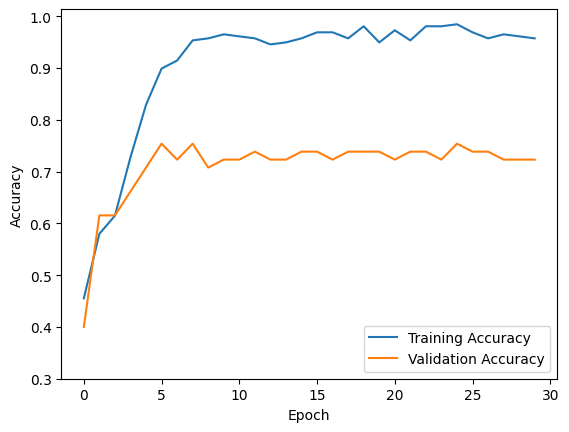

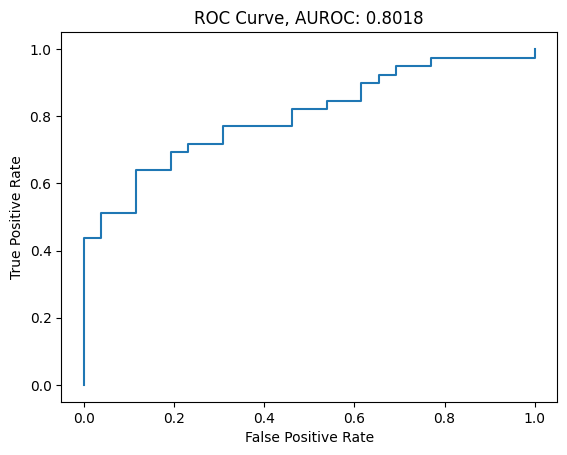

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# Main function
def main():
    num_epochs = 30

    accuracy_list = []
    loss_list = []
    val_accuracy_list = []
    val_loss_list = []

    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        val_loss, val_accuracy, loss, accuracy = train(model, train_loader, criterion, optimizer, best_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        scheduler.step()

        accuracy_list.append(accuracy)
        loss_list.append(loss)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)

    print("Finished training")

    binary_string = 'binary'
    row_norm_string = 'quantile'

    # Plot the training and validation loss
    plt.figure()
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yticks([i/10 for i in range(0, 20, 2)])
    plt.legend()
    plt.savefig(f"../Results_one_PD/loss_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    plt.clf()
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.yticks([i/10 for i in range(3, 11, 1)])
    plt.legend()
    plt.savefig(f"../Results_one_PD/accuracy_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Load the model (best or latest)
    model.load_state_dict(torch.load('best_model_one_pipeline_PD.pth'))

    model.eval()
    y_pred = []
    y_true = []
    y_pred_prob = pd.DataFrame()

    with torch.no_grad():
        for (data1, labels) in val_loader:

            outputs = model(data1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).numpy())
            y_pred_prob = pd.concat([y_pred_prob, pd.DataFrame(outputs.softmax(dim=1))], ignore_index=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(f"../Results_one_PD/confusion_matrix_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Plot ROC curve with thresholds from 0.1 to 0.9
    plt.clf()
    # Calculate the AUROC score
    fpr, tpr, thresholds = roc_curve(pd.DataFrame(y_true), y_pred_prob[1])
    print("Best cutoff threshold: ", thresholds[np.argmax(tpr - fpr)])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUROC: {:.4f}'.format(roc_auc_score(pd.DataFrame(y_true), y_pred_prob[1])))
    plt.savefig(f"../Results_one_PD/roc_curve_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    


if __name__ == '__main__':
    main()

Best cutoff threshold:  0.704853


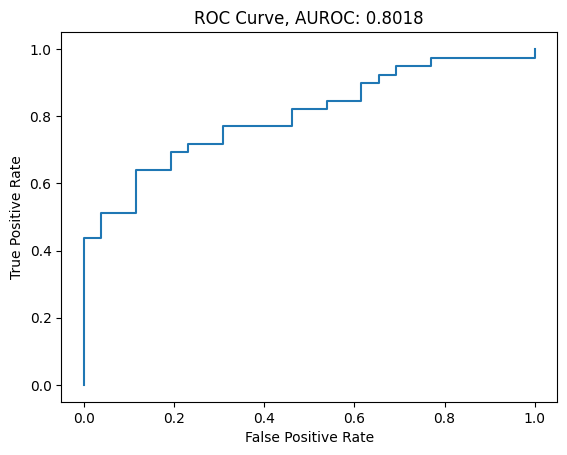

In [8]:
binary_string = 'binary'
row_norm_string = 'quantile'
num_epochs = 30

# Load the model (best or latest)
model.load_state_dict(torch.load('latest_model_one_pipeline_PD.pth'))

model.eval()
y_pred = []
y_true = []
y_pred_prob = pd.DataFrame()

with torch.no_grad():
    for (data1, labels) in val_loader:

        outputs = model(data1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).numpy())
        y_pred_prob = pd.concat([y_pred_prob, pd.DataFrame(outputs.softmax(dim=1))], ignore_index=True)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig(f"../Results_one_PD/latest_confusion_matrix_{binary_string}_{row_norm_string}_{num_epochs}_.png")

# Plot ROC curve with thresholds from 0.1 to 0.9
plt.clf()
# Calculate the AUROC score
fpr, tpr, thresholds = roc_curve(pd.DataFrame(y_true), y_pred_prob[1])
print("Best cutoff threshold: ", thresholds[np.argmax(tpr - fpr)])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, AUROC: {:.4f}'.format(roc_auc_score(pd.DataFrame(y_true), y_pred_prob[1])))
plt.savefig(f"../Results_one_PD/latest_roc_curve_{binary_string}_{row_norm_string}_{num_epochs}_.png")